# Interpretable Machine Learning: PD4

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import waterfall_chart

from scipy import stats
from xgboost import XGBClassifier

Przekopiowałem kod do wczytywania i transformacji danych oraz trenowania modelu z PD1.

In [3]:
path = r'D:\Interpretable Machine Learning\PD1\HCMST 2017 fresh sample for public sharing draft v1.1.dta'
data = pd.read_stata(path)

In [4]:
variables = ['ppage', 'w6_q24_length', 'w6_sex_frequency', 'w6_q23', 'w6_q27']
# Selecting variables
X = data[variables]
# Filtering observations
logical_filter = (~data.w6_q23.isna()) & (data.w6_q23 != 'Refused') & (data.w6_q27 != 'Refused')
X = X[logical_filter]
# Casting types and imputation
X.ppage = X.ppage.astype(float)
X.w6_q24_length = X.w6_q24_length.astype(float)
X.w6_sex_frequency = X.w6_sex_frequency.cat.codes.replace({-1:5, 0:5})
X.w6_q23 = X.w6_q23.astype(str)
X.w6_q27 = X.w6_q27.astype(str)
# One Hot Encoding
X = pd.get_dummies(X)
X.columns = map(lambda x: x.replace('[Partner Name]', 'PARTNER'), X.columns)

y = 1 - data.S1.cat.codes
y = y[logical_filter]

In [5]:
xgb = XGBClassifier(seed=123)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

## Definicja funkcji rysującej wykres do Variable Attribution

In [6]:
def VA_plot(model, X, obs, variable_order_list, predict_proba):
    obs = pd.DataFrame(obs).transpose()
    df = X.copy()
    df_to_add = X.copy()
    for var in variable_order_list:
        df_to_add[var] = obs[var].values[0]
        
        df = df.append(df_to_add)
        
    if predict_proba:
        preds = model.predict_proba(df)[:,1]
    else:
        preds = model.predict(df)
    to_plot = pd.DataFrame({'label':np.repeat(['pred_mean'] + list(map(lambda x: x[:10],variable_order_list)), X.shape[0]),
                            'pred':preds})
    to_plot = to_plot.groupby('label', sort=False).agg('mean')
    to_plot['pred'] = [to_plot['pred'][0]] + list(np.diff(to_plot['pred']))
    waterfall_chart.plot(to_plot.index,
                         to_plot['pred'],
                            formatting='{:,.3f}',)

## Definicja klasy tworzącej model LIME

Załóżmy, że wybraliśmy obserwację $X_i = (X_{i1}, ..., X_{ik})$. Dla danej obserwacji jej perturbacje generowane są następująco:

* Dla zmiennych ciągłych są losowane z rozkładu normalnego. Dla $j$-tej zmiennej ustalamy średnią jako $X_{ij}$, czyli wartość $j$-tej zmiennej dla wybranej $i$-tej obserwacji. Odchylenie standardowe jest wybierane jako odchylenie standardowe $j$-tej zmiennej w próbce uczącej, podzielone przez 3. Przy założeniu, że ta zmienna ma rozkład normalny, co oczywiście nie musi być prawdą, gwarantowałoby to, że z prawdopodobieństwem 99,7% wylosujemy liczbę odległą od średniej o co najwyżej odchylenie standardowe na próbce uczącej.
* Dla zmiennych dyskretnych są losowane z rozkładu dyskretnego z prawdopodobieństwami równymi częstościom na zbiorze treningowym.

Wykorzystano pakiet `statsmodels`, żeby podsumowanie modelu zawierało więcej informacji.

In [14]:
class LIME:
    def __init__(self, model, X, obs):
        self.model = model
        self.X = X
        self.obs = obs
        return
    
    def create_z(self, no_samples):
        z_dict = {}
        for var in self.X.columns:
            if self.X[var].dtype == np.float64:
                z_dict[var] = stats.norm.rvs(loc=self.obs[var], scale=X[var].std()/3, size=no_samples)
            else:
                values = X[var].value_counts().index
                probs = X[var].value_counts().values / X.shape[0]
                z_dict[var] = stats.rv_discrete(values=(values, probs)).rvs(size=no_samples)
        self.Z = pd.DataFrame(z_dict)
        
    def predict_for_z(self):
        self.y_Z = self.model.predict_proba(self.Z)[:,1]
        
    def train_wb_model(self):
        self.wb_model = sm.OLS(self.y_Z, self.Z).fit()
    
    def print_results(self):
        print(self.wb_model.summary())

## Wyjaśnianie modelu

Analogicznie do PD1, jako obserwację wybrano 32-letnią osobę, która o poznaniu swojego partnera napisała 348 znaków. Z partnerem uprawiała seks z partnerem 3 do 6 razy w tygodniu; w 2016 roku zarobiła więcej niż partner oraz dorastała z partnerem w tej samej miejscowości. Osoba ta nie była w związku małżeńskim.

In [8]:
obs = X.iloc[23,]
print(obs)
print(y[23])

ppage                                      32.0
w6_q24_length                             348.0
w6_sex_frequency                            2.0
w6_q23_I earned more                        1.0
w6_q23_We earned about the same amount      0.0
w6_q23_PARTNER earned more                  0.0
w6_q23_PARTNER was not working for pay      0.0
w6_q27_No                                   0.0
w6_q27_Yes                                  1.0
Name: 24, dtype: float64
0


Przyjąłem dwa podejścia. Najpierw rozważyłem zmienne w kolejności: numeryczne, porządkowa, dyskretne. W drugiej wersji odwrotnie - zaczynając od dyskretnych, a potem porządkowa i numeryczne w odwróconej kolejności.

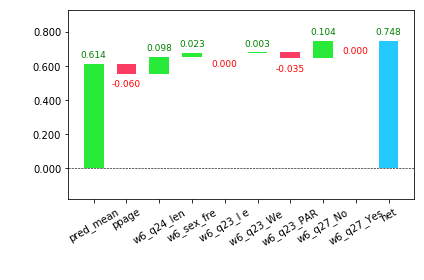

In [9]:
vlist1 = ['ppage', 
          'w6_q24_length', 
          'w6_sex_frequency', 
          'w6_q23_I earned more', 
          'w6_q23_We earned about the same amount', 
          'w6_q23_PARTNER earned more',
          'w6_q23_PARTNER was not working for pay',
          'w6_q27_No',
          'w6_q27_Yes']

VA_plot(xgb, X, obs, vlist1, True)

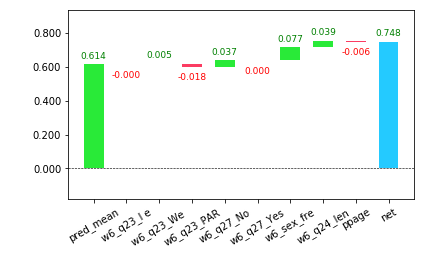

In [10]:
vlist2 = ['w6_q23_I earned more', 
          'w6_q23_We earned about the same amount', 
          'w6_q23_PARTNER earned more',
          'w6_q23_PARTNER was not working for pay',
          'w6_q27_No',
          'w6_q27_Yes',
          'w6_sex_frequency', 
          'w6_q24_length',
          'ppage']

VA_plot(xgb, X, obs, vlist2, True)

## LIME

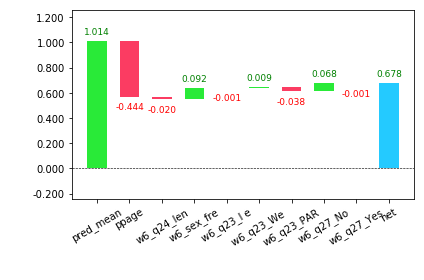

In [19]:
l = LIME(xgb, X, obs)
l.create_z(1000)
l.predict_for_z()
l.train_wb_model()
VA_plot(l.wb_model, X, obs, vlist1, False)

Oczywiście predykcja z modelu białej skrzynki niekoniecznie musi mieć sens - dla predykcji prawdopodobieństw model liniowy może wyjść poza przedział [0,1]. Ciekawa obserwacja jest taka, że dla wszystkich zmiennych poza `w6_q24_len` efekty implikowane przez model białej skrzynki mają taki sam znak jak dla wyjściowego modelu, co pokazuje powyższy wykres Variable Attribution. Biorąc pod uwagę, że wykresy VA zachowywały się podobnie niezależnie od permutacji zmiennych oraz VA dla modelu LIME również były podobne, można uznać, że obie metody dobrze odzwierciedlają zachowanie wyjściowego modelu w pobliżu naszej wybranej obserwacji.